# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [3]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: он вероятности показывает, тк вызываем метод predict_proba

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [4]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


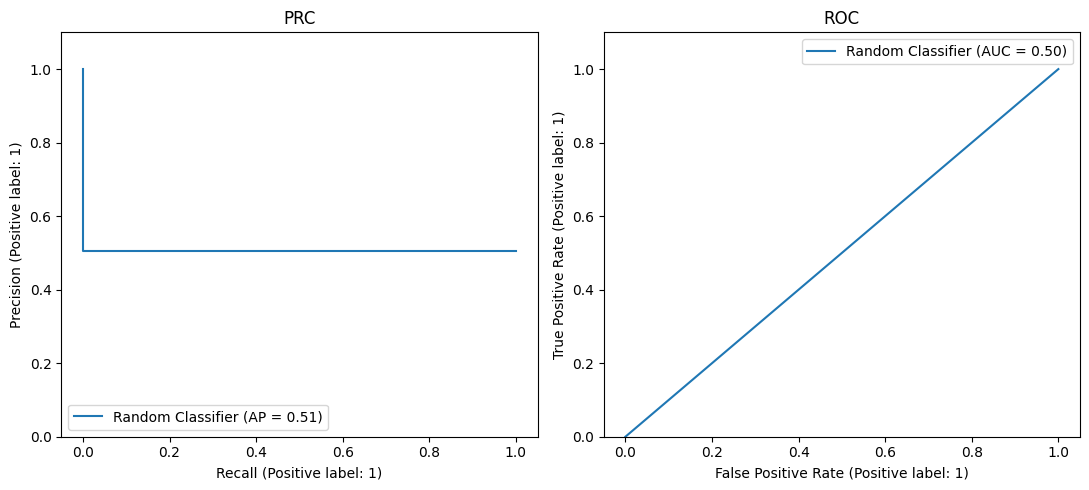

In [5]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [6]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [7]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import auc, precision_recall_curve

с_list = {'C': [0.1, 0.5, 1, 2, 5, 10]}
search = GridSearchCV(SVC(kernel='linear', probability=True), с_list,
                      cv=4, scoring='average_precision')
search.fit(X_train, y_train)
test_scores = search.decision_function(X_test)
precision, recall, _ = precision_recall_curve(y_test, test_scores)
test_auc_pr = auc(recall, precision)
print("Best C:", search.best_params_['C'])



Best C: 0.1


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

LinearSVC metrics
AUC-PR: 0.81486
AUC-ROC: 0.84789


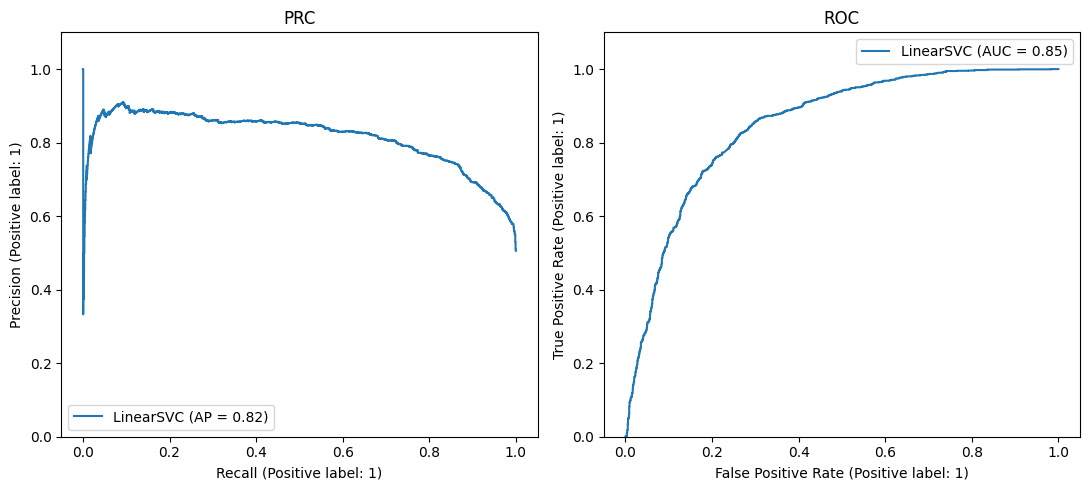

In [8]:
lr_probs = search.predict_proba(X_test)
lr_probs = lr_probs[:, 1]

depict_pr_roc(y_test, lr_probs, "LinearSVC")

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [11]:
df_metrics.loc['LinearSVC'] = [
      auc(recall, precision),
      roc_auc_score(y_test, test_scores),
      search.best_params_['C']
]
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.0
LinearSVC,0.814859,0.847896,0.1


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



LogisticRegression metrics
AUC-PR: 0.82917
AUC-ROC: 0.84785


,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.0
LinearSVC,0.814859,0.847896,0.1
LogisticRegression,0.829168,0.847846,0.1


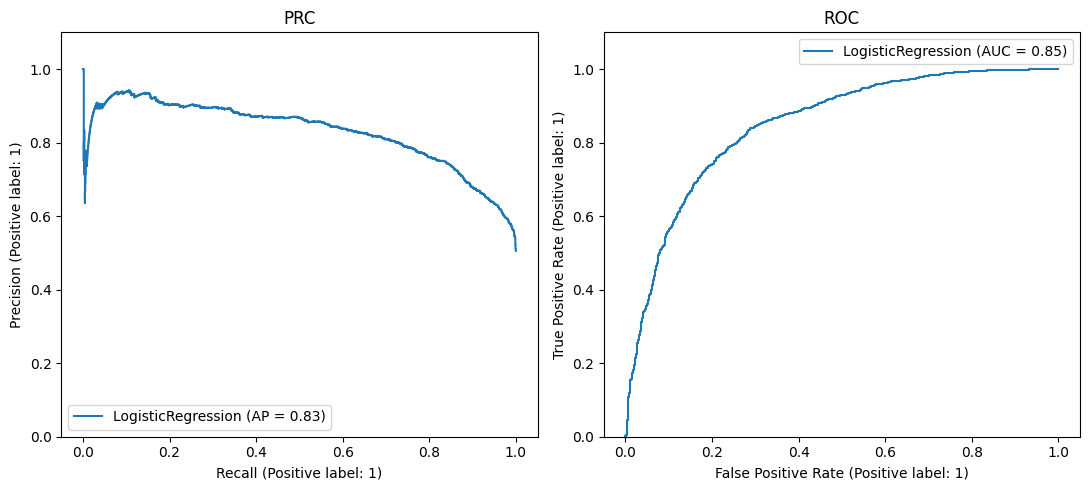

In [16]:
from sklearn. linear_model import LogisticRegression

с_list = {'C': [ 0.1, 0.5, 1, 2, 5, 10]}
log_regression = GridSearchCV(LogisticRegression(penalty='l2'), с_list,
                      cv=4, scoring='average_precision')
log_regression.fit(X_train, y_train)
test_scores = log_regression.decision_function(X_test)
precision_log, recall_log, _ = precision_recall_curve(y_test, test_scores)
test_auc_pr_log = auc(recall_log, precision_log)
y_random_log = log_regression.predict_proba(X_test)[:,1]
depict_pr_roc(y_test,y_random_log, "LogisticRegression")
df_metrics.loc['LogisticRegression'] = [
      auc(recall_log, precision_log),
      roc_auc_score(y_test, y_random_log),
      log_regression.best_params_['C']
]
df_metrics

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике


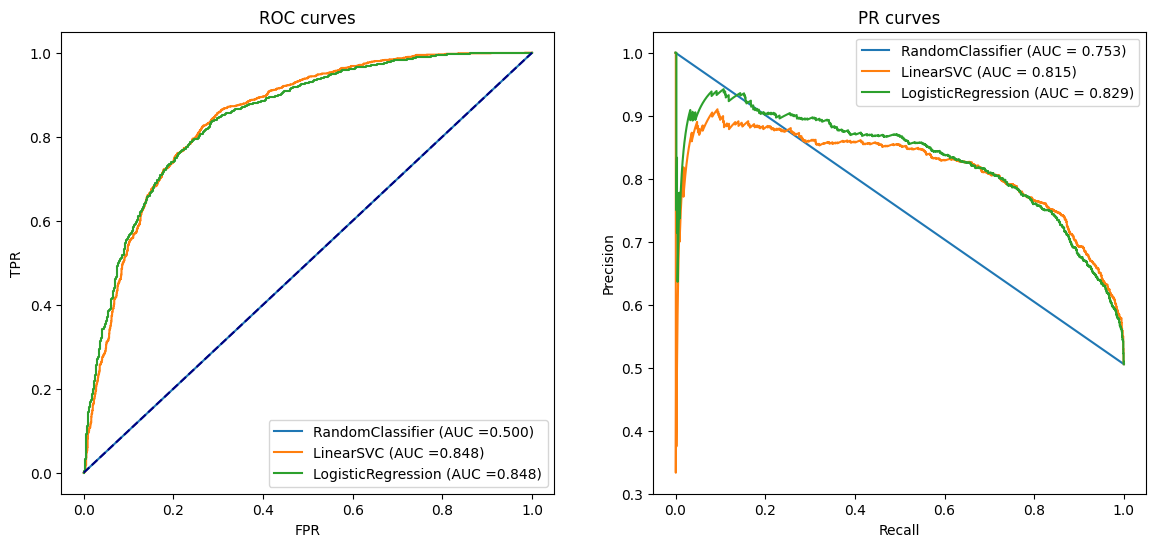

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
classifiers = [random_classifier, search, log_regression]
classifiers_names = ['RandomClassifier', 'LinearSVC', 'LogisticRegression']

for i, clf in enumerate(classifiers):
    name = classifiers_names[i]
    model = clf.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:,1]

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    ax[0].plot(fpr, tpr, label=f'{name} (AUC ={roc_auc:.3f})')

    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    ax[1].plot(recall, precision, label=f'{name} (AUC = {pr_auc:.3f})')

ax[0].plot([0, 1], [0, 1], color='navy', linestyle='--')
ax[0].legend()
ax[0].set_xlabel('FPR')
ax[0].set_ylabel('TPR')
ax[0].set_title('ROC curves')
ax[1].legend()
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('PR curves')

plt.show()

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** значения roc-auc получились одинаковыми, значения pr-auc различается минимально: возможно, причина в том, что логрегрессия автоматом калибрует вероятности, а svm нет, из-за чего результат может быть хуже

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [22]:
X, y = make_classification(n_samples=10000,n_features=2, n_informative=2, n_redundant=0, n_classes=2)

# Разделяем данные на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучаем метод опорных векторов
two_features_SVC = SVC(kernel='linear')
two_features_SVC.fit(X_train, y_train)
two_features_log = LogisticRegression()
two_features_log.fit(X_train, y_train)

LogisticRegression()

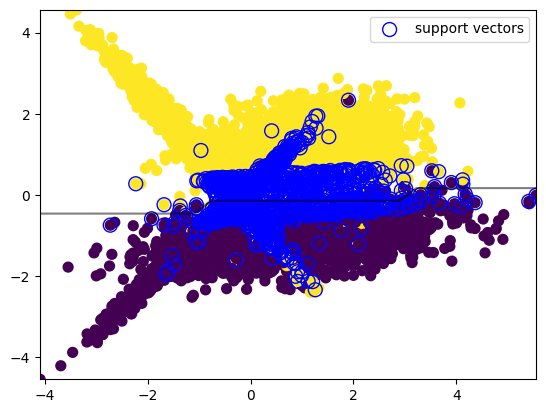

In [25]:
def plot_svm_2D(X, y, model, plot_support=True):
    xx, yy = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 30),
                         np.linspace(X[:, 1].min(), X[:, 1].max(), 30))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['-.', '-', '-.'])

    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')


    if plot_support:
        plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="blue",
                   facecolors='none')

    plt.legend()
plot_svm_2D(X, y, two_features_SVC)
plt.show()

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** они ближе всего находятся к разделяющей прямой


В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

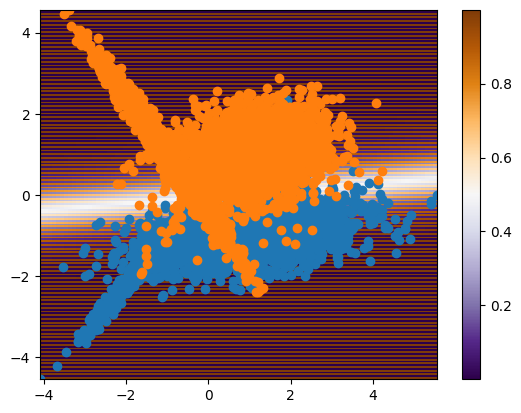

In [36]:
def plot_logreg_2D(X, y, model):
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.predict_proba(np.c_[XX.ravel(), YY.ravel()])
    Z = Z.reshape((xx.shape[0], -1)).T
    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)


    plt.scatter(X[y == 0, 0], X[y == 0, 1],  label='Класс 0')
    plt.scatter(X[y == 1, 0], X[y == 1, 1],  label='Класс 1')
    plt.colorbar(image)


plot_logreg_2D(X, y, two_features_log)
plt.show()

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** область, в которой модель не уверена - светлая линия на графике, модель переключается с одного класса на другой, тк 0.5 - порог по умолчанию порог, после которого модель приписывает объектам положительный класс

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [37]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) #было l-r
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) #было np.min
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

Text(0.5, 1.0, 'Калибровочная прямая логистической ргерессии ')

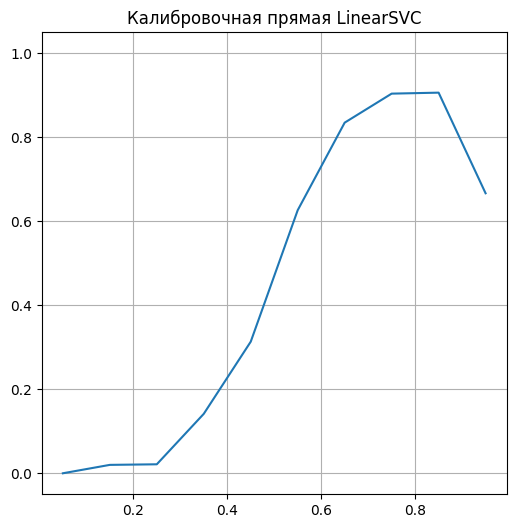

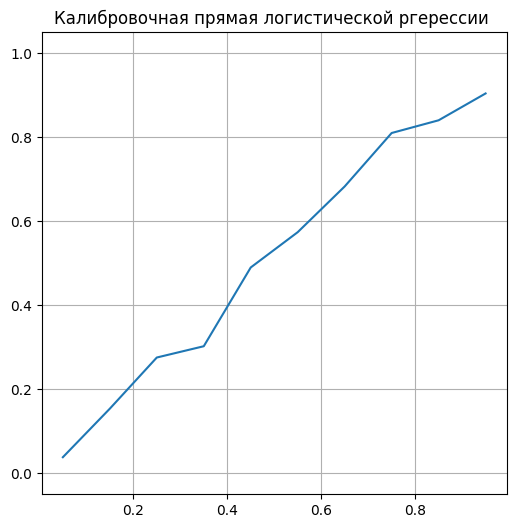

In [43]:

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
lr = LogisticRegression(max_iter=100000, C=0.1).fit(X_train, y_train)
svc = LinearSVC(max_iter=100000, C=0.1).fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)
lr_pred = lr.decision_function(X_test)
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min()) #нормализуем в нужный отрезок с помощью минмакса
lr_pred = lr.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test,svc_pred)
plt.title('Калибровочная прямая LinearSVC')

plot_calibration_curve(y_test,lr_pred)
plt.title('Калибровочная прямая логистической ргерессии ')


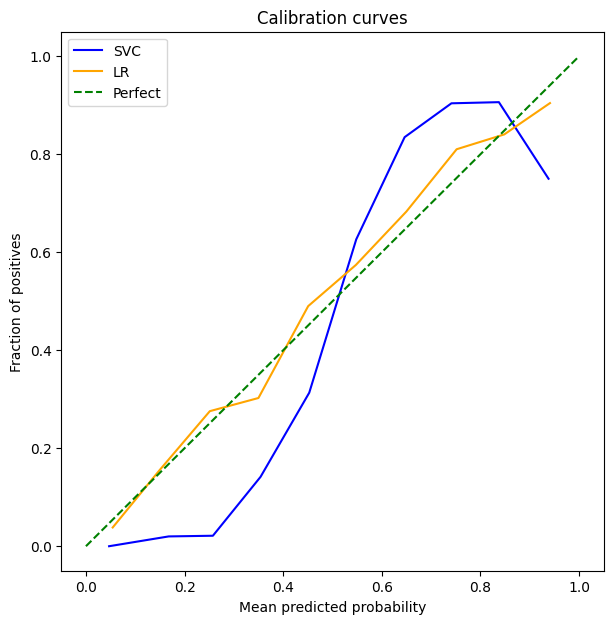

In [45]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(7, 7)) #из семинара

svc_true_prob, svc_pred_prob = calibration_curve(y_test, svc_pred, n_bins=10)
lr_true_prob, lr_pred_prob = calibration_curve(y_test, lr_pred, n_bins=10)

plt.plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
plt.plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves')
plt.legend()
plt.show()


**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** для логрегрессии - хорошо, для SVM - не очень


Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

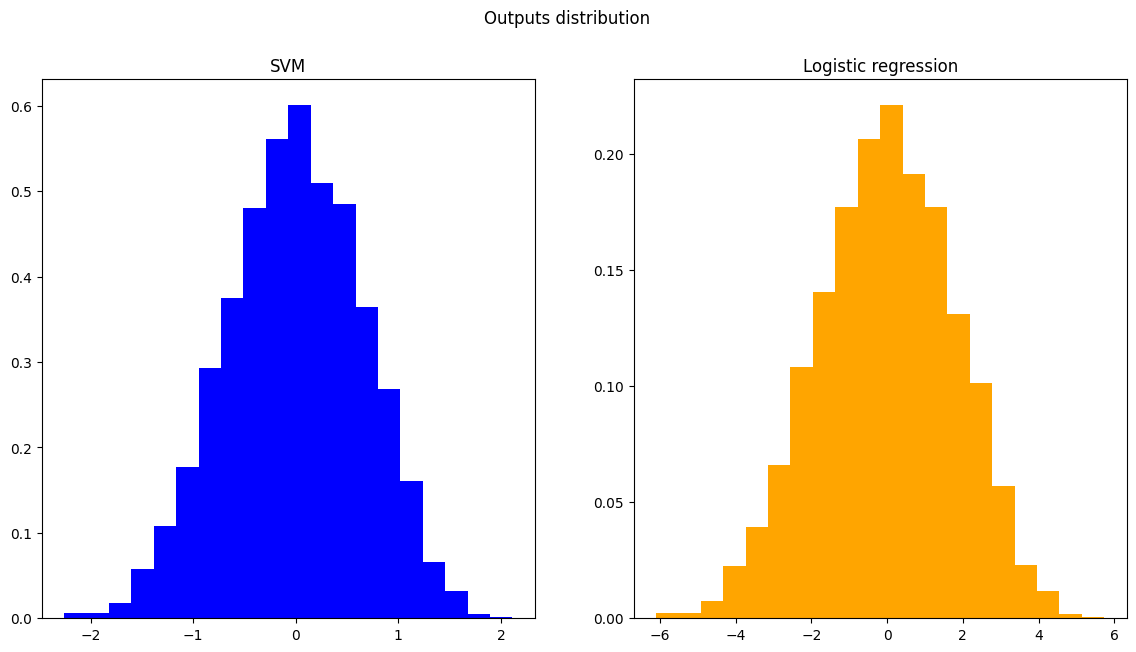

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
svc_pred = svc.decision_function(X_test)
lr_pred = lr.decision_function(X_test)
axs[0].hist(svc_pred, bins=20, color='blue', density='True')
axs[1].hist(lr_pred, bins=20, color='orange', density='True')

axs[0].set_title('SVM')
axs[1].set_title('Logistic regression')

plt.suptitle('Outputs distribution')
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** в SVM вероятности более скомпанованы, в логрегрессии диапазон, который занимают ответы классификатора больше, из-за чего плотность маленькая относительно SVM, возможно, различия из-за того что svm ищет гиперплоскость, которая максимизирует разницу между двумя классами данных, из-за чего разброс получаемых значений меньше и плотность больше

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

SVC ROC-AUC: 0.8476982154596746
SVC ROC-AUC: 0.8476322069812523


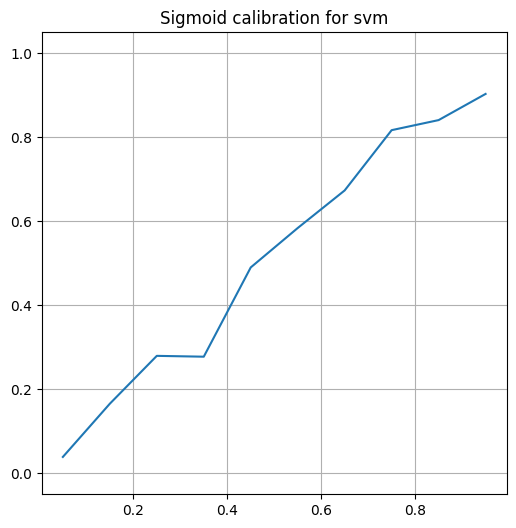

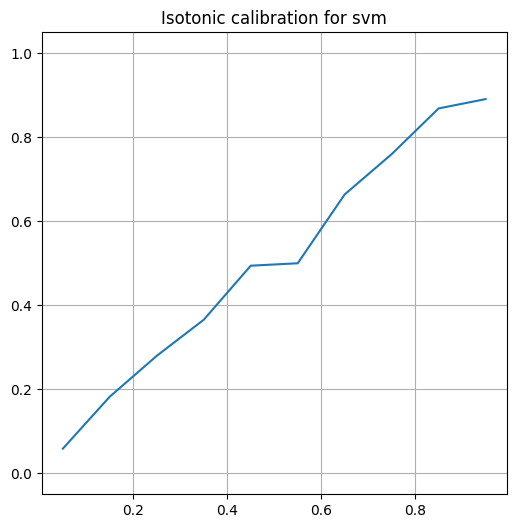

In [53]:
from sklearn.calibration import CalibratedClassifierCV

sigmoid_svc = CalibratedClassifierCV(svc, cv=4, method='sigmoid').fit(X_train, y_train)
sigmoid_svc_pred = sigmoid_svc.predict_proba(X_test)[:, 1]
print('SVC ROC-AUC:', roc_auc_score(y_test, sigmoid_svc_pred))

isotonic_svc = CalibratedClassifierCV(svc, cv=4, method='isotonic').fit(X_train, y_train)
isotonic_svc_pred = isotonic_svc.predict_proba(X_test)[:, 1]
print('SVC ROC-AUC:', roc_auc_score(y_test, isotonic_svc_pred))

plot_calibration_curve(y_test, sigmoid_svc_pred)
plt.title('Sigmoid calibration for svm')
plot_calibration_curve(y_test, isotonic_svc_pred)
plt.title('Isotonic calibration for svm');


**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** да

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [262]:
df = pd.read_csv('bike_buyers.csv')
X = df.drop(columns=['Purchased Bike','ID']) #дропаем айди, чтоб не переобучались под них
y = (df['Purchased Bike'] == 'Yes').astype('int64')

X_categorical = ['Marital Status','Gender',"Education","Occupation","Home Owner", "Commute Distance","Region"]
X_numerical = ["Income", "Children", "Cars","Age"]
X[X_categorical] = X[X_categorical].fillna('undefined')


В начале поработаем только с категориальными признаками

In [263]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)


#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [266]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
import time
from sklearn. linear_model import LogisticRegression

logistic = LogisticRegression()

column_transformer = ColumnTransformer([
    ("ordencoder", OrdinalEncoder(), X_categorical)
])

pipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('logistic', logistic),
])
start_time = time.time()
pipeline.fit(X_train,y_train)
end_time = time.time()


y_probs = pipeline.predict_proba(X_test)[:, 1]

auc_pr = average_precision_score(y_test, y_probs)
print("AUC-PR OrdinalEncoding:", auc_pr)
print("Time in seconds: ", end_time - start_time)


AUC-PR OrdinalEncoding: 0.5883009320176316
Time in seconds:  0.02190995216369629


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [267]:
from sklearn. preprocessing import OneHotEncoder

logistic = LogisticRegression()
column_transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(), X_categorical)
])

pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('logistic', logistic),
])
start_time = time.time()
pipeline.fit(X_train,y_train)
end_time = time.time()


y_probs = pipeline.predict_proba(X_test)[:, 1]

auc_pr = average_precision_score(y_test, y_probs)
print("AUC-PR для ohe:", auc_pr)
print("Time in seconds: ", end_time - start_time)

AUC-PR для ohe: 0.666642757355176
Time in seconds:  0.04741525650024414


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [70]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.1 MB/s eta 0:00:00


In [268]:
from category_encoders.target_encoder import TargetEncoder

column_transformer = ColumnTransformer([
    ('te', TargetEncoder(smoothing=1), X_categorical)
])

pipeline = Pipeline(steps=[
    ('transform', column_transformer),
    ('logistic', logistic),
])
start_time = time.time()
pipeline.fit(X_train,y_train)
end_time = time.time()


y_probs = pipeline.predict_proba(X_test)[:, 1]

auc_pr = average_precision_score(y_test, y_probs)
print("AUC-PR для счетчиков:", auc_pr)
print("Time in seconds: ", end_time - start_time)

AUC-PR для счетчиков: 0.6802583424342387
Time in seconds:  0.0971214771270752


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [269]:
from sklearn.base import BaseEstimator, TransformerMixin

class CounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features):
        self.categorical_features = categorical_features
        self.dictionary = {}

    def fit(self, X, y):
        data = pd.concat([X, y], axis=1)
        y_name = y.name
        for column in self.categorical_features:
            self.dictionary[column] =data.groupby([column])[y_name].mean()
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for column in list(self.dictionary.keys()):
            column_mean = self.dictionary[column].mean()
            X_transformed[column] = X_transformed[column].map(self.dictionary[column]).fillna(column_mean)
        return X_transformed
pipeline = Pipeline(steps=[
    ('transform', CounterTransformer(X_categorical)),
    ('logistic', logistic),
])

start_time = time.time()
pipeline.fit(X_train[X_categorical],y_train)
end_time = time.time()

y_probs = pipeline.predict_proba(X_test[X_categorical])[:, 1]

auc_pr = average_precision_score(y_test, y_probs)
print("AUC-PR для счетчиков:", auc_pr)
print("Time in seconds: ", end_time - start_time)

AUC-PR для счетчиков: 0.6575408792625901
Time in seconds:  0.024308443069458008


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [270]:
class CounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns, smoothing=10):
        self.categorical_columns = categorical_columns
        self.smoothing = smoothing
        self.dictionary = {}

    def fit(self, X, y):
        data = pd.concat([X, y], axis=1)
        y_name = y.name
        self.global_mean = y.mean()
        for column in self.categorical_columns:
            if X[column].dtype == 'object':
                count = data[column].value_counts()
                mean = data.groupby(column)[y_name].mean()
                smooth = (count * mean + self.smoothing ) / (count)
                self.dictionary[column] = smooth
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for column in self.categorical_columns:
            if column in self.dictionary:
                X_transformed[column] = X_transformed[column].map(self.dictionary[column])
        return X_transformed
parametrs = { 'logistic__C': np.arange(1,30,3)}

pipeline = Pipeline(steps=[
    ('transform', CounterTransformer(X_categorical)),
    ('logistic', logistic),
])
grid = GridSearchCV(pipeline, parametrs, cv=5)

start_time = time.time()
grid.fit(X_train[X_categorical],y_train)
end_time = time.time()


y_probs = grid.predict_proba(X_test[X_categorical])[:, 1]

auc_pr = average_precision_score(y_test, y_probs)
print("AUC-PR для счетчиков:", auc_pr)
print("Time in seconds: ", end_time - start_time)
grid.best_params_

AUC-PR для счетчиков: 0.620355586054864
Time in seconds:  3.3472299575805664


{'logistic__C': 7}

**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** не помогло, мы все-таки искажаем реальные признаки

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [271]:
from sklearn.model_selection import KFold #2 способ

class CounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns, smoothing=10, n_folds=10):
        self.categorical_columns = categorical_columns
        self.smoothing = smoothing
        self.n_folds = n_folds
        self.encoder_dict = {}

    def fit(self, X, y):
        kf = KFold(n_splits=self.n_folds)

        for train_index, val_index in kf.split(X):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, _ = y.iloc[train_index], y.iloc[val_index]
            data = pd.concat([X_train, y_train], axis=1)
            y_name = y.name

            for column in self.categorical_columns:
                if X[column].dtype == 'object':
                    count = data[column].value_counts()
                    mean = data.groupby(column)[y_name].mean()
                    smooth = (count * mean + self.smoothing ) / (count)
                    if column in self.encoder_dict:
                        self.encoder_dict[column] = (self.encoder_dict[column] * (self.n_folds - 1) + smooth) / self.n_folds
                    else:
                        self.encoder_dict[column] = smooth
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for column in self.categorical_columns:
            if column in self.encoder_dict:
                X_transformed[column] = X_transformed[column].map(self.encoder_dict[column])
        return X_transformed

parametrs = { 'logistic__C': np.arange(1,30,3)}
pipeline = Pipeline(steps=[
    ('transform', CounterTransformer(X_categorical)),
    ('logistic', logistic),
])
grid = GridSearchCV(pipeline, parametrs, cv=5)

start_time = time.time()
grid.fit(X_train[X_categorical],y_train)
end_time = time.time()
y_probs = grid.predict_proba(X_test[X_categorical])[:, 1]

auc_pr = average_precision_score(y_test, y_probs)
print("AUC-PR для счетчиков:", auc_pr)
print("Time in seconds: ", end_time - start_time)
grid.best_params_

AUC-PR для счетчиков: 0.6115309505456521
Time in seconds:  15.447913408279419


{'logistic__C': 7}

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [272]:
from sklearn.model_selection import GridSearchCV

class CounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns, C=None):
        self.categorical_columns = categorical_columns
        self.C = C
        self.dictionary = {}
        self.global_mean = None

    def fit(self, X, y):
        data = pd.concat([X, y], axis=1)
        y_name = y.name
        self.global_mean = y.mean()
        for column in self.categorical_columns:
                count = data[column].value_counts()
                mean = data.groupby(column)[y_name].mean()
                smooth = (count * mean + self.C * self.global_mean) / (count + self.C)
                self.dictionary[column] = smooth
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for column in self.categorical_columns:
            if column in self.dictionary:
                X_transformed[column] = X_transformed[column].map(self.dictionary[column])
        return X_transformed
parametrs = { 'transform__C': np.arange(0.1,20,3)}
pipeline = Pipeline(steps=[
    ('transform', CounterTransformer(X_categorical)),
    ('logistic', logistic),
])
grid = GridSearchCV(pipeline, parametrs, cv=5)
start_time = time.time()
grid.fit(X_train[X_categorical],y_train)
end_time = time.time()
y_probs = grid.predict_proba(X_test[X_categorical])[:, 1]

auc_pr = average_precision_score(y_test, y_probs)
print("AUC-PR для счетчиков:", auc_pr)
print("Time in seconds: ", end_time - start_time)
grid.best_params_

AUC-PR для счетчиков: 0.6691290886558048
Time in seconds:  1.4116358757019043


{'transform__C': 18.1}

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [273]:
class CounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, C=None):
        # self.categorical_columns = categorical_columns
        self.C = C
        self.dictionary = {}
        self.global_mean = None

    def fit(self, X, y):
        data = pd.concat([X, y], axis=1)
        y_name = y.name
        self.columns = X.columns
        self.global_mean = y.mean()
        for column in self.columns:
                count = data[column].value_counts()
                mean = data.groupby(column)[y_name].mean()
                smooth = (count * mean + self.C * self.global_mean) / (count + self.C)
                self.dictionary[column] = smooth
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for column in self.columns:
            if column in self.dictionary:
                X_transformed[column] = X_transformed[column].map(self.dictionary[column]).fillna(self.global_mean)
        return X_transformed
X_train=X_train.fillna(X_train.mean())
X_test=X_test.fillna(X_test.mean())

parametrs = { 'transform__C': np.arange(1,20,3)}
pipeline = Pipeline(steps=[
    ('transform', CounterTransformer()),
    ('logistic', logistic),
])
grid = GridSearchCV(pipeline, parametrs, cv=5)
start_time = time.time()
grid.fit(X_train,y_train)
end_time = time.time()
y_probs = grid.predict_proba(X_test)[:, 1]

auc_pr = average_precision_score(y_test, y_probs)
print("AUC-PR для счетчиков:", auc_pr)
print("Time in seconds: ", end_time - start_time)
grid.best_params_

AUC-PR для счетчиков: 0.6701886593468132
Time in seconds:  1.8418617248535156


{'transform__C': 10}

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [275]:
class CounterTransformer(BaseEstimator, TransformerMixin): # здесь каждый уникальный числовой признак кодируется по отдельности, не знаю, правильно ли поняла условие, вероятно, нет
    def __init__(self, categorical_columns, numeric_columns, C=1):
        self.categorical_columns = categorical_columns
        self.numeric_columns = numeric_columns
        self.C = C
        self.dictionary = {}
        self.global_mean = None
    def fit(self, X, y):
        data = pd.concat([X, y], axis=1)
        y_name = y.name
        self.global_mean = y.mean()
        self.dictionary = {}

        for column in self.categorical_columns:
            count = data[column].value_counts()
            mean = data.groupby(column)[y_name].mean()
            smooth = (count * mean + self.C * self.global_mean) / (count + self.C)
            self.dictionary[column] = smooth
        for column in self.numeric_columns:
            self.dictionary[column] = {}

            unique_values = data[column].unique()
            for value in unique_values:
                count = len(data[data[column]==value])
                mean = data[data[column]==value][y_name].mean()
                smooth = (count * mean + self.C * self.global_mean) / (count + self.C)
                self.dictionary[column][value] = smooth
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for column in (self.categorical_columns+self.numeric_columns):
            if column in self.dictionary:
                    X_transformed[column] = X_transformed[column].map(self.dictionary[column]).fillna(self.global_mean)

        return X_transformed
X_numeric=['Income','Children','Cars',"Age"]


parametrs = { 'transform__C': np.arange(1,20,3)}
pipeline = Pipeline(steps=[
    ('transform', CounterTransformer(X_categorical,X_numeric)),
    ('logistic', logistic),
])
grid = GridSearchCV(pipeline, parametrs, cv=5)
start_time = time.time()
grid.fit(X_train,y_train)
end_time = time.time()


y_probs = grid.predict_proba(X_test)[:, 1]

auc_pr = average_precision_score(y_test, y_probs)
print('Количество уникальных числовых признаков:', X_train[X_numeric].nunique() )
print("AUC-PR для счетчиков:", auc_pr)
print("Time in seconds: ", end_time - start_time)
grid.best_params_

Количество уникальных числовых признаков: Income      17
Children     7
Cars         6
Age         54
dtype: int64
AUC-PR для счетчиков: 0.6701886593468132
Time in seconds:  8.019275188446045


{'transform__C': 10}

In [289]:
class CounterTransformer(BaseEstimator, TransformerMixin):  #здесь я пыталась все уникальные числовые признаки сделать одним признаком и потом заменять по значению счетчика, но я не понимаю условиеееее
    def __init__(self, categorical_columns, numeric_columns, C=1):
        self.categorical_columns = categorical_columns
        self.numeric_columns = numeric_columns
        self.C = C
        self.dictionary = {}
        self.global_mean = None
        self.numeric_dict = {}

    def fit(self, X, y):
        data = pd.concat([X, y], axis=1)
        y_name = y.name
        self.global_mean = y.mean()

        for column in self.categorical_columns:
            count = data[column].value_counts()
            mean = data.groupby(column)[y_name].mean()
            smooth = (count * mean + self.C * self.global_mean) / (count + self.C)
            self.dictionary[column] = smooth.to_dict()

        for column in self.numeric_columns:
            unique_vals = data[column].unique()
            mean_dict = {val: data[data[column] == val][y.name].mean() for val in unique_vals}
            self.numeric_dict[column] = mean_dict

    def transform(self, X):
        X_transformed = X.copy()
        for column in self.categorical_columns:
            X_transformed[column] = X_transformed[column].map(self.dictionary.get(column)).fillna(self.global_mean)

        for column in self.numeric_columns:
            X_transformed[column] = X_transformed[column].map(self.numeric_dict.get(column)).fillna(self.global_mean)

        return X_transformed
X_numeric=['Income','Children','Cars', 'Age']

parametrs = {'countertransformer__C': np.arange(1,5,1)}
pipeline = Pipeline(steps=[
    ('countertransformer', CounterTransformer(X_categorical, X_numeric)),
    ('logistic', logistic)
])
grid = GridSearchCV(pipeline, parametrs, cv=5)
start_time = time.time()
grid.fit(X_train,y_train)
end_time = time.time()
y_probs = grid.predict_proba(X_test)[:, 1]

auc_pr = average_precision_score(y_test, y_probs)
print("AUC-PR для счетчиков:", auc_pr)
print("Time in seconds: ", end_time - start_time)
print("Best params: ", grid.best_params_)

ValueError: ignored

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ счетчики не плодят признаки-колонки и сохраняют информацию о распределении таргета внутри каждого признака (что также плохо, ибо информация о таргете утекает, можем переобучиться), счетчики также чувствительны к выбросам в признаках

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [142]:
import warnings
warnings.filterwarnings('ignore')


In [143]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2023-11-22 16:11:42--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data’

adult.data              [   <=>              ]   3.79M  7.13MB/s    in 0.5s    

2023-11-22 16:11:42 (7.13 MB/s) - ‘adult.data’ saved [3974305]



In [247]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df= pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [248]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['income']) #дропаем айди, чтоб не переобучались под них
y = (df['income'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)


Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [249]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import time
logistic = LogisticRegression(solver='lbfgs')
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
amount_before=len(categorical)
column_transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(), categorical)
])
pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('logistic', logistic),
])
start_time = time.time()
pipeline.fit(X_train,y_train)
end_time = time.time()
amount_after = pipeline.named_steps['ohe'].transformers_[0][1].get_feature_names_out(input_features=categorical).shape[0]

y_probs = pipeline.predict_proba(X_test)[:, 1]

auc_pr = average_precision_score(y_test, y_probs)
print(f"Time in seconds: {end_time-start_time}, AUC_PR: {auc_pr}")
print("Количество признаков до ohe: ", amount_before)
print("Количество признаков после ohe: ", amount_after)


Time in seconds: 0.2479085922241211, AUC_PR: 0.6854872202828091
Количество признаков до ohe:  8
Количество признаков после ohe:  102


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [250]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectFromModel
coef = pipeline.named_steps['logistic'].coef_[0]
selected_feature_indices = np.argsort(np.abs(coef))[-40:]
selected_columns = np.array(column_transformer.get_feature_names_out())[selected_feature_indices]
selected_pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('feature_selection', FunctionTransformer(lambda data: data[:, selected_feature_indices])),
    ('logistic', logistic),
])

start_time = time.time()
selected_pipeline.fit(X_train, y_train)
end_time = time.time()
y_probs = selected_pipeline.predict_proba(X_test)[:, 1]
auc_pr = average_precision_score(y_test, y_probs)
print(f"Time in seconds: {end_time-start_time}, AUC_PR: {auc_pr}")
print(selected_columns)

Time in seconds: 0.24263763427734375, AUC_PR: 0.6485266834722337
['ohe__native-country_ England' 'ohe__occupation_ Tech-support'
 'ohe__relationship_ Other-relative' 'ohe__occupation_ Prof-specialty'
 'ohe__workclass_ Federal-gov'
 'ohe__marital-status_ Married-spouse-absent'
 'ohe__occupation_ Farming-fishing'
 'ohe__native-country_ Dominican-Republic' 'ohe__native-country_ Hong'
 'ohe__occupation_ Protective-serv'
 'ohe__native-country_ Outlying-US(Guam-USVI-etc)' 'ohe__sex_ Female'
 'ohe__native-country_ Germany' 'ohe__native-country_ Nicaragua'
 'ohe__education_ 5th-6th' 'ohe__marital-status_ Separated'
 'ohe__occupation_ Other-service' 'ohe__native-country_ Italy'
 'ohe__native-country_ France' 'ohe__education_ Bachelors'
 'ohe__native-country_ Canada' 'ohe__education_ 10th'
 'ohe__education_ 11th' 'ohe__native-country_ Cambodia'
 'ohe__workclass_ Without-pay' 'ohe__occupation_ Exec-managerial'
 'ohe__education_ 1st-4th' 'ohe__relationship_ Wife' 'ohe__education_ 9th'
 'ohe__educa

Изменилось ли качество? Как? Качество ухудшилось

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [251]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
logistic = LogisticRegression(solver='lbfgs')
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
numerical = X_train.select_dtypes(include=np.number).columns.tolist()

column_transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numerical)
])

pipeline_scaled = Pipeline(steps=[
    ('ohe', column_transformer),
    ('logistic', logistic),
])
start_time = time.time()
pipeline_scaled.fit(X_train,y_train)
end_time = time.time()

y_probs = pipeline_scaled.predict_proba(X_test)[:, 1]

auc_pr = average_precision_score(y_test, y_probs)
print(f"Time in seconds: {end_time-start_time}, AUC_PR: {auc_pr}")



Time in seconds: 0.48719096183776855, AUC_PR: 0.7671938697586204


Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [252]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

ohe_scaler_pipeline = Pipeline([
    ('ohe', OneHotEncoder()),
    ('scaler', StandardScaler(with_mean=False))
])
column_transformer = ColumnTransformer([
    ('ohe_and_scaling', ohe_scaler_pipeline, categorical), #cкалируем все признаки
    ('scaling', StandardScaler(), numerical)
])
pipeline_scaled = Pipeline(steps=[
    ('transformers', column_transformer),
    ('logistic', logistic),
])
start_time = time.time()
pipeline_scaled.fit(X_train, y_train)
end_time = time.time()

y_probs = pipeline_scaled.predict_proba(X_test)[:, 1]

auc_pr = average_precision_score(y_test, y_probs)
print(f"Time in seconds: {end_time-start_time}, AUC_PR: {auc_pr}")


Time in seconds: 0.3871901035308838, AUC_PR: 0.7661167079938189


In [253]:
from sklearn.feature_selection import SelectFromModel
coef = pipeline_scaled.named_steps['logistic'].coef_[0]
selected_feature_indices = np.argsort(np.abs(coef))[-40:]
selected_columns = np.array(column_transformer.get_feature_names_out())[selected_feature_indices]
selected_pipeline = Pipeline(steps=[
    ('transformers', column_transformer),
    ('feature_selection', FunctionTransformer(lambda data: data[:, selected_feature_indices])),
    ('logistic', logistic),
])
start_time = time.time()
selected_pipeline.fit(X_train, y_train)
end_time = time.time()

y_probs = selected_pipeline.predict_proba(X_test)[:, 1]

auc_pr = average_precision_score(y_test, y_probs)
print(f"Time in seconds: {end_time-start_time}, AUC_PR: {auc_pr}") #качество чуть ухудшилось
print(selected_columns) #список изменился

Time in seconds: 0.33173489570617676, AUC_PR: 0.7615148801725888
['ohe_and_scaling__education_ Prof-school'
 'ohe_and_scaling__occupation_ Prof-specialty'
 'ohe_and_scaling__occupation_ ?' 'ohe_and_scaling__education_ Masters'
 'ohe_and_scaling__native-country_ Dominican-Republic'
 'ohe_and_scaling__education_ 7th-8th'
 'ohe_and_scaling__relationship_ Other-relative'
 'ohe_and_scaling__marital-status_ Widowed'
 'ohe_and_scaling__native-country_ Columbia'
 'ohe_and_scaling__relationship_ Not-in-family'
 'ohe_and_scaling__education_ 10th'
 'ohe_and_scaling__marital-status_ Married-spouse-absent'
 'ohe_and_scaling__native-country_ Outlying-US(Guam-USVI-etc)'
 'ohe_and_scaling__native-country_ United-States'
 'ohe_and_scaling__occupation_ Handlers-cleaners'
 'ohe_and_scaling__workclass_ Without-pay'
 'ohe_and_scaling__education_ 11th' 'ohe_and_scaling__education_ HS-grad'
 'ohe_and_scaling__race_ White' 'ohe_and_scaling__native-country_ Mexico'
 'ohe_and_scaling__workclass_ Self-emp-not-in

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [254]:
from sklearn.feature_selection import SelectKBest
def t_val_calc(X, y):
    t_values = []
    for i in range(X.shape[1]):
        x_i = X[:, i] #каждая колонка по отдельности
        x_i_pos = x_i[y == 1] #отбираем колонки, у которых таргет 1
        x_i_neg = x_i[y == 0] #отбираем колонки, у которых таргет 0
        mean_diff = np.abs(np.mean(x_i_pos) - np.mean(x_i_neg)) #разность средних
        var_pos = np.var(x_i_pos) * len(x_i_pos)
        var_neg = np.var(x_i_neg) * len(x_i_neg)
        t_value = mean_diff / np.sqrt((var_pos + var_neg) / len(y))
        t_values.append(t_value)
    return np.array(t_values)
def t_values(X, y):
    t_values = t_val_calc(X, y)
    return t_values, None
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse=False), categorical),
    ('scaling', StandardScaler(), numerical)
])
pipeline_filter = Pipeline(steps=[
    ('transformers', column_transformer),
    ('feature_selection',SelectKBest(score_func=t_values, k=40)),
    ('logistic', logistic),
])

start_time = time.time()
pipeline_filter.fit(X_train,y_train)
end_time = time.time()
y_probs = pipeline_filter.predict_proba(X_test)[:, 1]
auc_pr = average_precision_score(y_test, y_probs)
print(f"Time in seconds: {end_time-start_time}, AUC_PR: {auc_pr}")


Time in seconds: 0.4125232696533203, AUC_PR: 0.7621197324599572


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [168]:
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [255]:
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
numerical = X_train.select_dtypes(include=np.number).columns.tolist()

X_train_rfe, X_val_rfe, y_train_rfe, y_val_rfe = train_test_split(X_train, y_train, test_size=0.5, random_state=777)

column_transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numerical)
])
pipeline = make_pipeline(
    column_transformer,
    RFE(LogisticRegression(solver='lbfgs'), n_features_to_select=40),
    LogisticRegression(solver='lbfgs')
)

start_time = time.time()
pipeline.fit(X_train_rfe, y_train_rfe)
end_time = time.time()

val_probs = pipeline.predict_proba(X_val_rfe)[:, 1]
test_probs = pipeline.predict_proba(X_test)[:, 1]

val_precision, val_recall, _ = precision_recall_curve(y_val_rfe, val_probs)
test_precision, test_recall, _ = precision_recall_curve(y_test, test_probs)

val_pr_auc = auc(val_recall, val_precision)
test_pr_auc = auc(test_recall, test_precision)
print(f" AUC_PR for validation sample: {val_pr_auc}")
print(f"Time in seconds: {end_time-start_time}, AUC_PR for test: {test_pr_auc}")

 AUC_PR for validation sample: 0.7383074180661782
Time in seconds: 9.058223962783813, AUC_PR for test: 0.7397941334179303


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [256]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

scorer = make_scorer(average_precision_score, needs_proba=True, greater_is_better=True)
column_transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numerical)
])

X_train_trans = column_transformer.fit_transform(X_train)
pipeline_logistic = Pipeline(steps=[
    ('logistic', LogisticRegression(solver="lbfgs"))
])
sfs = SFS(
    pipeline_logistic,
    k_features=40,
    forward=True,
    floating=False,
    scoring=scorer,
    n_jobs=-1,
)
start_time = time.time()
sfs.fit(X_train_trans, y_train)
end_time = time.time()

for i in range(1, 41):
    print(f"For {i} features, best score: {sfs.subsets_[i]['avg_score']}") #вроде такого порога нет



For 1 features, best score: 0.44530123546391687
For 2 features, best score: 0.615951823669164
For 3 features, best score: 0.699064811184275
For 4 features, best score: 0.7245255248067469
For 5 features, best score: 0.7370553375728386
For 6 features, best score: 0.7451550554859356
For 7 features, best score: 0.7504710746843466
For 8 features, best score: 0.753756823102256
For 9 features, best score: 0.7558786326663849
For 10 features, best score: 0.7574692565373666
For 11 features, best score: 0.7587643376361749
For 12 features, best score: 0.7597803428655375
For 13 features, best score: 0.7606100111370272
For 14 features, best score: 0.7612802352855016
For 15 features, best score: 0.7618176961370275
For 16 features, best score: 0.7623518238960176
For 17 features, best score: 0.7627549066012123
For 18 features, best score: 0.7631185174878248
For 19 features, best score: 0.7635181769898801
For 20 features, best score: 0.7637960150911616
For 21 features, best score: 0.764096525190707
For 

In [257]:
X_selected_features = sfs.transform(X_train_trans)
pipeline_logistic.fit(X_selected_features, y_train)

X_test_trans = column_transformer.transform(X_test)
X_test_trans = sfs.transform(X_test_trans)

y_probs = pipeline_logistic.predict_proba(X_test_trans)[:, 1]
auc_pr = average_precision_score(y_test, y_probs)
print(f"Time in seconds: {end_time-start_time}, AUC_PR: {auc_pr}")
print('Best score: ', sfs.k_score_)

Time in seconds: 1895.769915819168, AUC_PR: 0.7663119360866537
Best score:  0.7683999534130916


<Figure size 3000x3000 with 0 Axes>

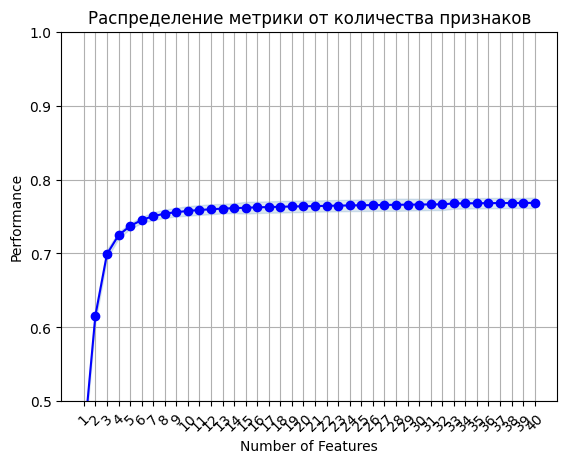

In [258]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 30))
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.ylim([0.5, 1])
plt.xticks (rotation= 45 )

plt.title('Распределение метрики от количества признаков')
plt.grid()
plt.show();

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Метод обертки в обратную сторону привел к наилучшему результату, однако ушло достаточно много времени и можно переобучиться, ohe плодит много признаков, поэтому нужно изначально масштабировать признаки и отбирать наиболее важные, также можно переобучиться, метод фильтрации дает практически такой же результат, что и метод обертки, но ушло значительно меньше времени - есть риск переобучения, если объектов мало

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [219]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
# !unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')


In [220]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [221]:
y = (df['y']=='yes' )
X = df.drop(columns=['duration', 'y'])


В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [222]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [223]:
kf = KFold(n_splits=5, shuffle=True, random_state=500)


Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [224]:
categorical = list(X.dtypes[X.dtypes == "object"].index)
numerical = X.select_dtypes(include=np.number).columns.tolist()

column_transformer = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(), categorical),
        ('scale', StandardScaler(), numerical)
    ]
)

model = make_pipeline(column_transformer, LogisticRegression())
scores = cross_val_score(model, X, y, cv=kf, scoring = 'accuracy' ) #вроде не сказано, какой скоринг использовать, поэтому взяла акураси
print(scores)


[0.90373877 0.89973294 0.89694101 0.90724778 0.89097973]


Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [225]:
earnings, cost = 10,1
total_profit = []
total_cost=[]
for train_index, test_index in kf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    successful_calls = ((y_pred == 1) & (y_test == 1)).sum()

    total_calls = len(y_pred==True)
    earnings_one_fold = earnings * successful_calls - cost * total_calls #10*только на тех клиентов, кто правда готов принести деньги и мы это предсказали - все, кому мы позвонили
    total_profit.append(earnings_one_fold)
    total_cost.append(cost * total_calls)


print("Average profit: ", np.mean(total_profit))
print("Standard deviation of profit: ", np.std(total_profit))
print('Total cost of labour for each fold:', *total_cost)


Average profit:  -6109.6
Standard deviation of profit:  102.55652100183586
Total cost of labour for each fold: 8238 8238 8238 8237 8237


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [227]:
import random
cost=1
total_profit, total_cost = [], []
for train_index, test_index in kf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    successful_calls = ((y_pred == 1) & (y_test == 1)).sum()
    total_calls = len(y_pred==True)
    earnings = [random.uniform(0, 20) for _ in range(total_calls)]
    earnings_one_fold = sum(earnings) * successful_calls - cost * total_calls
    total_profit.append(earnings_one_fold)
    total_cost.append(cost * total_calls)
print("Average profit: ", np.mean(total_profit))
print("Standard deviation of profit: ", np.std(total_profit))
print('Total cost of labour for each fold:', *total_cost)
#выручка выросла в разы

Average profit:  17518686.968541138
Standard deviation of profit:  867265.4459753034
Total cost of labour for each fold: 8238 8238 8238 8237 8237


In [ ]:
import random
cost=1
total_profit, total_cost = [], []
for train_index, test_index in kf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    reg_coef= random.uniform(0, 20)
    model = make_pipeline(column_transformer, LogisticRegression(C=reg_coeff))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    total_calls = y_pred.sum()
    earnings = [random.uniform(0, 20) for _ in range(total_calls)]
    earnings_one_fold = sum(earnings) - cost * total_calls
    total_profit.append(earnings_one_fold)
    total_cost.append(cost * total_calls)



Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [228]:
import numpy as np
import matplotlib.pyplot as plt

cost = 1
regularization_coeffs =  np.arange(1, 20)
expected_profits = []
std_deviations = []

for reg_coeff in regularization_coeffs:
    total_profit = []
    total_cost = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = make_pipeline(column_transformer, LogisticRegression(C=reg_coeff))
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        successful_calls = ((y_pred == 1) & (y_test == 1)).sum()
        total_calls = len(y_pred==True)
        earnings = [random.uniform(0, 20) for _ in range(total_calls)]
        earnings_one_fold =sum(earnings) * successful_calls - cost * total_calls
        total_profit.append(earnings_one_fold)
        total_cost.append(cost * total_calls)

    expected_profit = np.mean(total_profit)
    std_deviation = np.std(total_profit)

    expected_profits.append(expected_profit)
    std_deviations.append(std_deviation)
idx = np.argmax(expected_profits)
best_reg_coeff = regularization_coeffs[idx]


Лучший коэффициент регуляризации 8 при нем прибыль равна 17652755.303155415


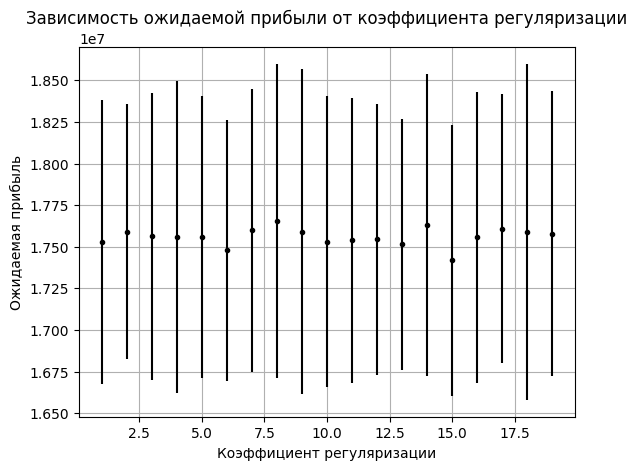

In [229]:
print('Лучший коэффициент регуляризации', best_reg_coeff, 'при нем прибыль равна', max(expected_profits) )
plt.errorbar(regularization_coeffs, expected_profits, yerr=std_deviations, fmt='.k')
plt.xlabel('Коэффициент регуляризации')
plt.ylabel('Ожидаемая прибыль')
plt.title('Зависимость ожидаемой прибыли от коэффициента регуляризации')
plt.grid(True)
plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [230]:
best_exp_profit=[]
reg_coef_for_each_iter=[]
for i in range(10):
    cost = 1
    regularization_coeffs =  np.arange(1, 10)
    expected_profits = []
    std_deviations = []

    for reg_coeff in regularization_coeffs:
        total_profit = []
        total_cost = []
        for train_index, test_index in kf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model = make_pipeline(column_transformer, LogisticRegression(C=reg_coeff))
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            successful_calls = ((y_pred == 1) & (y_test == 1)).sum()
            total_calls = len(y_pred==True)
            earnings = [random.uniform(0, 20) for _ in range(total_calls)]
            earnings_one_fold =sum(earnings) * successful_calls - cost * total_calls
            total_profit.append(earnings_one_fold)
            total_cost.append(cost * total_calls)

        expected_profit = np.mean(total_profit)
        std_deviation = np.std(total_profit)

        expected_profits.append(expected_profit)
        std_deviations.append(std_deviation)
    best_exp_profit.append(max(expected_profits))
    reg_coef_for_each_iter.append(regularization_coeffs[np.argmax(expected_profits)])

([17598126.310599595,
  17626924.19427259,
  17607905.876175728,
  17644544.520125393,
  17651227.3399105,
  17581286.887478728,
  17594764.535784114,
  17601844.783830747,
  17629722.584659852,
  17600280.801609643],
 [8, 4, 8, 9, 3, 6, 8, 8, 2, 6])

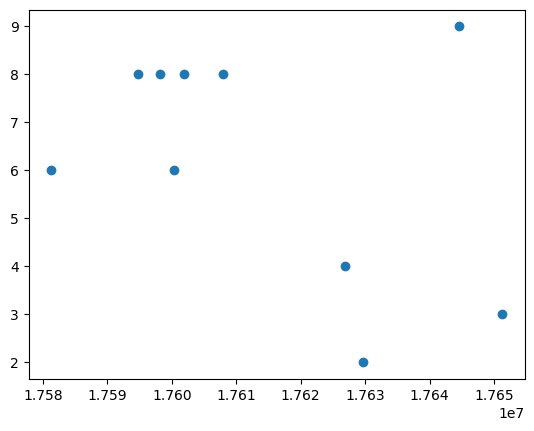

In [231]:
plt.scatter(best_exp_profit, reg_coef_for_each_iter)
(best_exp_profit, reg_coef_for_each_iter) #чаще всего находится 8 как и выше, значит данные более-менее стабильны и случайное разбиение выборки не так сильно влияет на результат

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ recall важнее, тк показывает, как много положительных случаев модель смогла правильно обнаружить из общего числа положительных случаев, нам важно не упустить клиентов, которые могут захотеть оплатить услугу



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




In [233]:
from sklearn.metrics import confusion_matrix

best_threshold = 0
best_profit = 0
cost = 1
thresholds = np.arange(0, 1.01, 0.01)
profits = []
profits_std = []

for threshold in thresholds:
    threshold_profits = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = make_pipeline(column_transformer, LogisticRegression(C=8))
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        y_pred = (y_pred_proba > threshold).astype(int)

        confusion = confusion_matrix(y_test, y_pred)
        successful_calls = confusion[1, 1]
        total_calls = confusion.sum()

        earnings = np.random.uniform(0, 20, total_calls)
        earnings_one_fold = np.sum(earnings) * successful_calls - cost * total_calls

        threshold_profits.append(earnings_one_fold)

    mean_profit = np.mean(threshold_profits)
    profits.append(mean_profit)
    profits_std.append(np.std(threshold_profits))

    if mean_profit > best_profit:
        best_profit = mean_profit
        best_threshold = threshold

print("Лучший порог:", best_threshold, "- прибыль:", best_profit)

Лучший порог: 0.01 - прибыль: 76615787.04267086


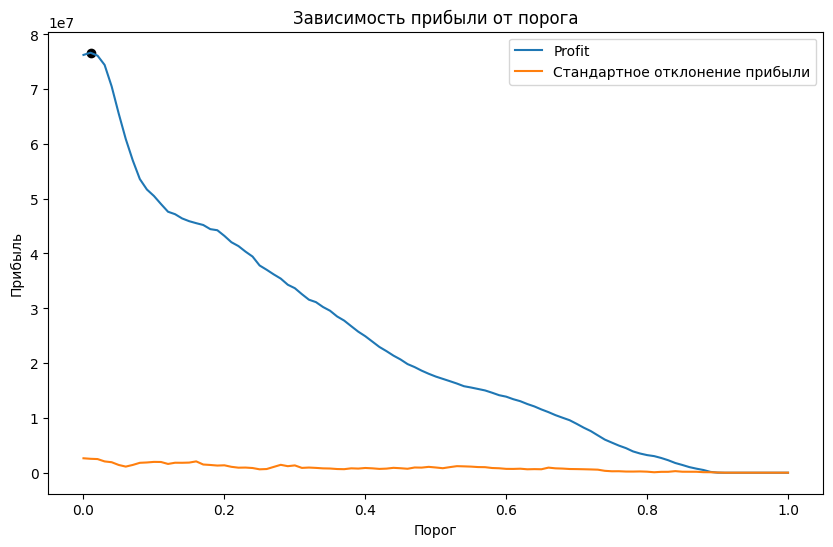

In [234]:

plt.figure(figsize=(10, 6))
plt.plot(thresholds, profits, label='Profit')
plt.plot(thresholds, profits_std, label='Стандартное отклонение прибыли')

plt.scatter(best_threshold, best_profit, color='black')
plt.legend()
plt.xlabel('Порог')
plt.ylabel('Прибыль')
plt.title('Зависимость прибыли от порога')
plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ порог получается одним и тем же,так как мы максимизируем прибыль, которая достигает пика тогда, когда recall максимальный, то есть в ситуации, когда мы нашли почти всех клиентов, которые нам готовы принести денежки (несмотря на рандомность суммы, у нас низкие издержки на труд, из-за чего мы не будем в выигрыше от звонка только тогда, когда клиент платит меньше 1 у.е.), поэтому стремимся найти всех клиентов и максимизировать полноту, снижая порог)

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [239]:
from sklearn.metrics import precision_score, recall_score

precisions = []
recalls = []
for train_index, test_index in kf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]

    y_pred = (y_pred_proba > best_threshold).astype(int)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precisions.append(precision)
    recalls.append(recall)
print(f'Значения precision на каждом фолде:{precisions}, std={np.std(precisions)}')
print(f'Значения recall на каждом фолде: {recalls}, std= {np.std(recalls)}')

Значения precision на каждом фолде:[0.11320296368274019, 0.11146187469645459, 0.11376881981544439, 0.10714285714285714, 0.11792567403449114], std=0.0034962210291141623
Значения recall на каждом фолде: [1.0, 1.0, 1.0, 1.0, 1.0], std= 0.0


Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [241]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import auc
import numpy as np

thresholds = np.arange(0, 1.01, 0.01)
recalls = []
precisions = []
total_pr_auc = 0
num_iterations = 0

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    idx = recall >= 0.5
    recall = recall[idx]
    precision = precision[idx]

    if len(recall) > 0:
        recall_rescale = (recall - 0.5) / 0.5
        precision_rescale = precision / max(precision)
        pr_auc = auc(recall_rescale, precision_rescale)
        total_pr_auc += pr_auc
        num_iterations += 1

avg_pr_auc = total_pr_auc / num_iterations if num_iterations > 0 else 0

print(f'Average PR AUC for recall>=0.5: {avg_pr_auc}')

Average PR AUC for recall>=0.5: 0.5496070430107047


__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ шарики несквик